In [1]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import pandas as pd
import sklearn.ensemble
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, matthews_corrcoef, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statistics
import numpy as np
from sklearn import tree

In [2]:
df = pd.read_csv("data/4.2_hg38_paired_introns.tsv", sep="\t")
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,repeat_features_end_site:Dust,repeat_features_end_site:Type II Transposons,repeat_features_end_site:RNA repeats,repeat_features_end_site:Low complexity regions,repeat_features_end_site:Simple repeats,repeat_features_end_site:Centromere,sequence,sequence_maxentscan,hg38 - Acceptor splice site,hg38 - Donor splice site
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,0,0,0,0,0,0,GTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGCCGG...,ccaGTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGC...,GT,AG
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,0,0,0,0,0,0,GTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTAGGG...,gagGTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTA...,GT,AG
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,0,0,0,0,0,0,CACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGG...,gagCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAG...,CA,GA
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,0,0,0,0,0,0,GTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAGTGA...,cttGTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAG...,GT,AG
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,0,0,0,0,0,0,GCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGGAGA...,tagGCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGG...,GC,AG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499138,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,0,0,GTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGCCTT...,aatGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGC...,GT,GC
499139,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,0,0,GTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAG...,cagGTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATT...,GT,AG
499140,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,0,0,ATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGACTTC...,gggATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGAC...,AT,AG
499141,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,0,0,CCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCACTCG...,cgcCCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCAC...,CC,AG


In [3]:
df_maxentscan_score = pd.read_csv("data/4.3_maxentscan", sep="\t")
df_nearest_ss_dist = pd.read_csv("data/4.4-nearest_ss_distance.tsv", sep="\t")
df_better_rc3_ss = pd.read_csv("data/4.6-better-nearby-match-and-rc3.tsv", sep="\t")
df_better_rc3_ss_10 = pd.read_csv("data/4.6-better-nearby-match-and-rc3-10nt.tsv", sep="\t")
df_splam_score = pd.read_csv("data/junction_score.bed", sep="\t", names=["chr", "start", "end", "junction_number", "class", "strand", "splam_donor_score", "splam_acceptor_score", "empty"])[["chr", "start", "end", "strand", "splam_donor_score", "splam_acceptor_score"]]
df_splam_score

,chr,start,end,strand,splam_donor_score,splam_acceptor_score
0,chr1,12227,12612,+,0.999925,0.999858
1,chr1,12721,13220,+,0.999545,0.999214
2,chr1,12057,12178,+,0.100124,0.533779
3,chr1,12697,12974,+,0.996771,0.984649
4,chr1,13052,13220,+,0.225408,0.238977
...,...,...,...,...,...,...
499124,chrY,24883840,24886132,+,0.990309,0.990025
499125,chrY,24888605,24889352,+,0.999873,0.999675
499126,chrY,24889386,24901111,+,0.627168,0.496720
499127,chrY,24833970,24840730,+,0.233837,0.496705


In [4]:
df["5_MaxEntScan"] = df_maxentscan_score["5_MaxEntScan"]
df["3_MaxEntScan"] = df_maxentscan_score["3_MaxEntScan"]
del df_maxentscan_score
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,repeat_features_end_site:RNA repeats,repeat_features_end_site:Low complexity regions,repeat_features_end_site:Simple repeats,repeat_features_end_site:Centromere,sequence,sequence_maxentscan,hg38 - Acceptor splice site,hg38 - Donor splice site,5_MaxEntScan,3_MaxEntScan
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,0,0,0,0,GTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGCCGG...,ccaGTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGC...,GT,AG,9.09,11.90
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,0,0,0,0,GTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTAGGG...,gagGTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTA...,GT,AG,7.66,3.89
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,0,0,0,0,CACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGG...,gagCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAG...,CA,GA,-13.87,-31.99
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,0,0,0,0,GTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAGTGA...,cttGTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAG...,GT,AG,7.15,7.61
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,0,0,0,0,GCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGGAGA...,tagGCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGG...,GC,AG,1.14,3.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499138,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,GTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGCCTT...,aatGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGC...,GT,GC,5.55,-9.69
499139,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,GTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAG...,cagGTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATT...,GT,AG,9.43,10.01
499140,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,ATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGACTTC...,gggATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGAC...,AT,AG,-14.46,7.85
499141,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,0,0,0,0,CCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCACTCG...,cgcCCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCAC...,CC,AG,-27.63,4.64


In [5]:
df["nearest_start_ss_dist"] = df_nearest_ss_dist["nearest_start_ss_dist"]
df["nearest_end_ss_dist"] = df_nearest_ss_dist["nearest_end_ss_dist"]
del df_nearest_ss_dist
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,repeat_features_end_site:Simple repeats,repeat_features_end_site:Centromere,sequence,sequence_maxentscan,hg38 - Acceptor splice site,hg38 - Donor splice site,5_MaxEntScan,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,0,0,GTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGCCGG...,ccaGTAAGTAGTGCTTGTGCTCATCTCCTTGGCTGTGATACGTGGC...,GT,AG,9.09,11.90,170,362
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,0,0,GTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTAGGG...,gagGTGAGAGGAGAGTAGACAGTGAGTGGGAGTGGCGTCGCCCCTA...,GT,AG,7.66,3.89,24,232
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,0,0,CACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGG...,gagCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAG...,CA,GA,-13.87,-31.99,170,434
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,0,0,GTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAGTGA...,cttGTGAGTGTCCCCAGTGTTGCAGAGGTGAGAGGAGAGTAGACAG...,GT,AG,7.15,7.61,24,246
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,0,0,GCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGGAGA...,tagGCAAGCCTGGCTGCCTCCAGCTGGGTCGACAGACAGGGGCTGG...,GC,AG,1.14,3.89,322,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499138,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,0,0,GTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGCCTT...,aatGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAGGC...,GT,GC,5.55,-9.69,5,16
499139,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,0,0,GTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATTGAG...,cagGTAATGTAAGAAGGAGTAAAATTATTTGCTTTCAGGTATTATT...,GT,AG,9.43,10.01,2384,819
499140,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,0,0,ATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGACTTC...,gggATTATGTTTTCCTTGATGTTAAGTGAATTAGCCAAACATAGAC...,AT,AG,-14.46,7.85,781,4072
499141,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,0,0,CCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCACTCG...,cgcCCTTGGTTTTCCTTACACCTTAGCCTTTGGCTCCTTTGACCAC...,CC,AG,-27.63,4.64,159,421


In [6]:
df["better_match_5nt_start_ss"] = df_better_rc3_ss["better_match_5nt_start_ss"]
df["better_match_10nt_start_ss"] = df_better_rc3_ss_10["better_match_5nt_start_ss"]
df["better_match_5nt_end_ss"] = df_better_rc3_ss["better_match_5nt_end_ss"]
df["better_match_10nt_end_ss"] = df_better_rc3_ss_10["better_match_5nt_end_ss"]
del df_better_rc3_ss
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,hg38 - Acceptor splice site,hg38 - Donor splice site,5_MaxEntScan,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,GT,AG,9.09,11.90,170,362,False,False,False,False
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,GT,AG,7.66,3.89,24,232,True,True,False,False
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,CA,GA,-13.87,-31.99,170,434,False,False,False,False
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,GT,AG,7.15,7.61,24,246,True,True,False,False
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,GC,AG,1.14,3.89,322,232,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499138,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,GT,GC,5.55,-9.69,5,16,True,True,False,False
499139,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,GT,AG,9.43,10.01,2384,819,True,True,False,False
499140,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,AT,AG,-14.46,7.85,781,4072,False,False,False,False
499141,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,CC,AG,-27.63,4.64,159,421,False,False,False,False


In [7]:
# df["splam_donor_score"] = df_splam_score["splam_donor_score"]
# df["splam_acceptor_score"] = df_splam_score["splam_acceptor_score"]
df["intron_length"] = df["sequence"].apply(len)
df = df[df.intron_length > 4]

In [8]:
df = df.merge(df_splam_score, how="left", on=["chr", "start", "end", "strand"])
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_donor_score,splam_acceptor_score
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,11.90,170,362,False,False,False,False,385,0.999925,0.999858
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,3.89,24,232,True,True,False,False,499,0.999545,0.999214
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,-31.99,170,434,False,False,False,False,121,0.100124,0.533779
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,7.61,24,246,True,True,False,False,277,0.996771,0.984649
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,3.89,322,232,False,False,False,False,168,0.225408,0.238977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499090,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,-9.69,5,16,True,True,False,False,2292,0.990309,0.990025
499091,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,10.01,2384,819,True,True,False,False,747,0.999873,0.999675
499092,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,7.85,781,4072,False,False,False,False,11725,0.627168,0.496720
499093,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,4.64,159,421,False,False,False,False,6760,0.233837,0.496705


In [9]:
df["splam_score_min"] = df[["splam_donor_score", "splam_acceptor_score"]].min(axis=1)


In [10]:
df = df.drop(columns=["splam_donor_score", "splam_acceptor_score"])
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,GTExv2,TCGAv2,SRAv3h,...,5_MaxEntScan,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_score_min
0,chr1,12227,12612,+,1,False,False,1122:3199,583:1460,9374:54492,...,9.09,11.90,170,362,False,False,False,False,385,0.999858
1,chr1,12721,13220,+,1,False,False,1791:3198,783:1104,14048:56719,...,7.66,3.89,24,232,True,True,False,False,499,0.999214
2,chr1,12057,12178,+,1,False,False,NaN,NaN,NaN,...,-13.87,-31.99,170,434,False,False,False,False,121,0.100124
3,chr1,12697,12974,+,1,False,False,1:1,1:1,15:19,...,7.15,7.61,24,246,True,True,False,False,277,0.984649
4,chr1,13052,13220,+,1,False,False,22:24,17:18,433:484,...,1.14,3.89,322,232,False,False,False,False,168,0.225408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499090,chrY,24883840,24886132,+,0,False,False,NaN,NaN,NaN,...,5.55,-9.69,5,16,True,True,False,False,2292,0.990025
499091,chrY,24888605,24889352,+,0,False,False,NaN,NaN,NaN,...,9.43,10.01,2384,819,True,True,False,False,747,0.999675
499092,chrY,24889386,24901111,+,0,False,False,NaN,NaN,NaN,...,-14.46,7.85,781,4072,False,False,False,False,11725,0.496720
499093,chrY,24833970,24840730,+,0,False,False,NaN,NaN,NaN,...,-27.63,4.64,159,421,False,False,False,False,6760,0.233837


In [11]:
df = df.drop(columns=["GTExv2", "TCGAv2", "SRAv3h",], axis=1)
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,RC3-Splice_site,RC3-Score,repeat_features_start_site:Unknown,...,5_MaxEntScan,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_score_min
0,chr1,12227,12612,+,1,False,False,GT:AG,59151,0,...,9.09,11.90,170,362,False,False,False,False,385,0.999858
1,chr1,12721,13220,+,1,False,False,GT:AG,61021,0,...,7.66,3.89,24,232,True,True,False,False,499,0.999214
2,chr1,12057,12178,+,1,False,False,NaN,-1,0,...,-13.87,-31.99,170,434,False,False,False,False,121,0.100124
3,chr1,12697,12974,+,1,False,False,GT:AG,21,0,...,7.15,7.61,24,246,True,True,False,False,277,0.984649
4,chr1,13052,13220,+,1,False,False,GC:AG,526,0,...,1.14,3.89,322,232,False,False,False,False,168,0.225408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499090,chrY,24883840,24886132,+,0,False,False,NaN,-1,0,...,5.55,-9.69,5,16,True,True,False,False,2292,0.990025
499091,chrY,24888605,24889352,+,0,False,False,NaN,-1,0,...,9.43,10.01,2384,819,True,True,False,False,747,0.999675
499092,chrY,24889386,24901111,+,0,False,False,NaN,-1,0,...,-14.46,7.85,781,4072,False,False,False,False,11725,0.496720
499093,chrY,24833970,24840730,+,0,False,False,NaN,-1,0,...,-27.63,4.64,159,421,False,False,False,False,6760,0.233837


In [12]:
df = df[((df["hg38 - Acceptor splice site"] == "GT") & (df["hg38 - Donor splice site"] == "AG")) | (df["hg38 - Acceptor splice site"] == "GC") & (df["hg38 - Donor splice site"] == "AG") | (df["hg38 - Acceptor splice site"] == "AT") & (df["hg38 - Donor splice site"] == "AC")]

In [13]:
df["splice-site"] = df["hg38 - Acceptor splice site"] + ":" + df["hg38 - Donor splice site"]


le = preprocessing.LabelEncoder()
le.fit(df["splice-site"])
df["splice-site"] = le.transform(df["splice-site"])

/tmp/ipykernel_53235/4075531358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["splice-site"] = df["hg38 - Acceptor splice site"] + ":" + df["hg38 - Donor splice site"]
/tmp/ipykernel_53235/4075531358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["splice-site"] = le.transform(df["splice-site"])


In [14]:
# df = df[(df["splice-site"] == 182) | (df["splice-site"] == 148) | (df["splice-site"] == 49)]
df

,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,RC3-Splice_site,RC3-Score,repeat_features_start_site:Unknown,...,3_MaxEntScan,nearest_start_ss_dist,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_score_min,splice-site
0,chr1,12227,12612,+,1,False,False,GT:AG,59151,0,...,11.90,170,362,False,False,False,False,385,0.999858,2
1,chr1,12721,13220,+,1,False,False,GT:AG,61021,0,...,3.89,24,232,True,True,False,False,499,0.999214,2
3,chr1,12697,12974,+,1,False,False,GT:AG,21,0,...,7.61,24,246,True,True,False,False,277,0.984649,2
4,chr1,13052,13220,+,1,False,False,GC:AG,526,0,...,3.89,322,232,False,False,False,False,168,0.225408,1
5,chr1,13374,13452,+,1,False,False,NaN,-1,0,...,7.63,322,232,False,False,False,False,78,0.004987,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499085,chrY,24874059,24874791,+,0,False,False,NaN,-1,0,...,9.37,12,816,True,True,False,False,732,0.819053,2
499086,chrY,24859737,24888533,+,0,False,False,NaN,-1,0,...,9.47,2390,2384,True,True,False,False,28796,1.000000,2
499087,chrY,24869268,24873975,+,0,False,False,NaN,-1,0,...,9.28,22,2377,False,False,False,False,4707,0.050199,2
499088,chrY,24893374,24894122,+,0,False,False,NaN,-1,0,...,10.11,2385,820,True,True,False,False,748,0.999903,2


In [15]:
# Extra feature engineering
# TODO should be integrated back into the previous steps

def calculate_gc_content(sequence):
    return (sequence.count('G') + sequence.count('C')) / len(sequence)

df["GC_content"] = df["sequence"].apply(calculate_gc_content)

/tmp/ipykernel_53235/3485735374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GC_content"] = df["sequence"].apply(calculate_gc_content)


In [16]:
def calculate_cpg_island(sequence):
    c_count = sequence.count('C')
    g_count = sequence.count('G')
    cg_count = sequence.count('CG')
    total_count = len(sequence)

    try:
        cpg_ratio = (cg_count * total_count) / (c_count * g_count)
        gc_content = (c_count + g_count) / total_count
    except ZeroDivisionError:
        # handle sequences with no 'C' or 'G' nucleotides
        cpg_ratio = 0
        gc_content = 0

    return cpg_ratio > 0.6 and gc_content > 0.5

df["CpG_island"] = df["sequence"].apply(calculate_cpg_island)

/tmp/ipykernel_53235/4006297594.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CpG_island"] = df["sequence"].apply(calculate_cpg_island)


In [17]:
df['intron_phase'] = df['start'] % 3

/tmp/ipykernel_53235/1466315001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intron_phase'] = df['start'] % 3


In [18]:
# le = preprocessing.LabelEncoder()
# le.fit(df["hg38 - Acceptor splice site"])
# df["hg38 - Acceptor splice site"] = le.transform(df["hg38 - Acceptor splice site"])
#
# le = preprocessing.LabelEncoder()
# le.fit(df["hg38 - Donor splice site"])
# df["hg38 - Donor splice site"] = le.transform(df["hg38 - Donor splice site"])

# le = preprocessing.LabelEncoder()
# le.fit(df["splice-site"])
# df["splice-site"] = le.transform(df["splice-site"])

le = preprocessing.LabelEncoder()
le.fit(df["ss_antisense_start_site"])
df["ss_antisense_start_site"] = le.transform(df["ss_antisense_start_site"])

le = preprocessing.LabelEncoder()
le.fit(df["ss_antisense_end_site"])
df["ss_antisense_end_site"] = le.transform(df["ss_antisense_end_site"])

df

/tmp/ipykernel_53235/3183689895.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ss_antisense_start_site"] = le.transform(df["ss_antisense_start_site"])
/tmp/ipykernel_53235/3183689895.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ss_antisense_end_site"] = le.transform(df["ss_antisense_end_site"])


,chr,start,end,strand,class,ss_antisense_start_site,ss_antisense_end_site,RC3-Splice_site,RC3-Score,repeat_features_start_site:Unknown,...,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_score_min,splice-site,GC_content,CpG_island,intron_phase
0,chr1,12227,12612,+,1,0,0,GT:AG,59151,0,...,False,False,False,False,385,0.999858,2,0.638961,False,2
1,chr1,12721,13220,+,1,0,0,GT:AG,61021,0,...,True,True,False,False,499,0.999214,2,0.597194,False,1
3,chr1,12697,12974,+,1,0,0,GT:AG,21,0,...,True,True,False,False,277,0.984649,2,0.595668,False,1
4,chr1,13052,13220,+,1,0,0,GC:AG,526,0,...,False,False,False,False,168,0.225408,1,0.595238,False,2
5,chr1,13374,13452,+,1,0,0,NaN,-1,0,...,False,False,False,False,78,0.004987,2,0.538462,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499085,chrY,24874059,24874791,+,0,0,0,NaN,-1,0,...,True,True,False,False,732,0.819053,2,0.307377,False,0
499086,chrY,24859737,24888533,+,0,0,0,NaN,-1,0,...,True,True,False,False,28796,1.000000,2,0.354876,False,0
499087,chrY,24869268,24873975,+,0,0,0,NaN,-1,0,...,False,False,False,False,4707,0.050199,2,0.331421,False,0
499088,chrY,24893374,24894122,+,0,0,0,NaN,-1,0,...,True,True,False,False,748,0.999903,2,0.318182,False,1


In [19]:
le = preprocessing.LabelEncoder()
le.fit(df["chr"])
df["chr"] = le.transform(df["chr"])

/tmp/ipykernel_53235/1990613794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["chr"] = le.transform(df["chr"])


In [20]:
df_annot_test_y = df.pop("class")
df_annot_test_y

0         1
1         1
3         1
4         1
5         1
         ..
499085    0
499086    0
499087    0
499088    0
499091    0
Name: class, Length: 466540, dtype: int64

In [21]:
# df["RC3-Score-25"] = df["RC3-Score"] >= 25

# Drop the columns that might not be available prior to manual gene annotation or irrelevant to ML
df_annot_test_X_1 = df.drop(["chr", "start", "end", "strand", "RC3-Splice_site", "sequence", "hg38 - Donor splice site", "hg38 - Acceptor splice site", "sequence_maxentscan",
                             "repeat_features_end_site:Unknown", "repeat_features_start_site:Dust", "repeat_features_end_site:Dust", "repeat_features_start_site:RNA repeats",
                             "repeat_features_end_site:RNA repeats", "repeat_features_end_site:Centromere", "repeat_features_start_site:Centromere", "repeat_features_start_site:Unknown",
                             "repeat_features_start_site:Low complexity regions", "repeat_features_end_site:Low complexity regions", "splice-site"], axis=1)

# FIXME
# df_annot_test_X_1 = df_annot_test_X_1[(df_annot_test_X_1["hg38 - Acceptor splice site"] == 13) & (df_annot_test_X_1["hg38 - Donor splice site"] == 2)]


In [22]:
df_annot_test_y

0         1
1         1
3         1
4         1
5         1
         ..
499085    0
499086    0
499087    0
499088    0
499091    0
Name: class, Length: 466540, dtype: int64

In [23]:
df_annot_test_X_1

,ss_antisense_start_site,ss_antisense_end_site,RC3-Score,repeat_features_start_site:Satellite repeats,repeat_features_start_site:Tandem repeats,repeat_features_start_site:Type I Transposons/LINE,repeat_features_start_site:Type I Transposons/SINE,repeat_features_start_site:LTRs,repeat_features_start_site:Type II Transposons,repeat_features_start_site:Simple repeats,...,nearest_end_ss_dist,better_match_5nt_start_ss,better_match_10nt_start_ss,better_match_5nt_end_ss,better_match_10nt_end_ss,intron_length,splam_score_min,GC_content,CpG_island,intron_phase
0,0,0,59151,0,0,0,0,0,0,0,...,362,False,False,False,False,385,0.999858,0.638961,False,2
1,0,0,61021,0,0,0,0,0,0,0,...,232,True,True,False,False,499,0.999214,0.597194,False,1
3,0,0,21,0,0,0,0,0,0,0,...,246,True,True,False,False,277,0.984649,0.595668,False,1
4,0,0,526,0,0,0,0,0,0,0,...,232,False,False,False,False,168,0.225408,0.595238,False,2
5,0,0,-1,0,0,0,0,0,0,0,...,232,False,False,False,False,78,0.004987,0.538462,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499085,0,0,-1,0,0,0,0,0,0,0,...,816,True,True,False,False,732,0.819053,0.307377,False,0
499086,0,0,-1,0,0,0,0,0,0,0,...,2384,True,True,False,False,28796,1.000000,0.354876,False,0
499087,0,0,-1,0,0,0,0,0,0,0,...,2377,False,False,False,False,4707,0.050199,0.331421,False,0
499088,0,0,-1,0,0,0,0,0,0,0,...,820,True,True,False,False,748,0.999903,0.318182,False,1


In [24]:
X_train_val = df_annot_test_X_1.copy()
y_train_val = df_annot_test_y.copy()
del df_annot_test_X_1
del df_annot_test_y

In [32]:
cv_acc_list = []
cv_ba_acc_list = []
cv_rocauc_list = []
cv_precision_list = []
cv_recall_list = []
cv_mcc_list = []
cv_specificity_list = []
cv_sensitivity_list = []
cv_fpr_list = []
cv_fnr_list = []
model_dict = {}
model_index = 0
cv_predicted_labels = []
cv_true_labels = []
matrix = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf.get_n_splits(X_train_val, y_train_val)

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train_resampled = X_train_val.iloc[train_index]
    y_train_resampled = y_train_val.iloc[train_index].to_numpy().flatten()

    X_train, X_val = X_train_resampled, X_train_val.iloc[val_index]
    y_train, y_val = y_train_resampled, y_train_val.iloc[val_index].to_numpy().flatten()

    model_dict[model_index] = XGBClassifier(random_state=77, scale_pos_weight=float((499143-402454)/499143)) #tree.DecisionTreeClassifier()
    model_dict[model_index].fit(X_train, y_train)

    y_predict = model_dict[model_index].predict_proba(X_val)
    y_predict = y_predict[:, 1]
    # y_predict_class = list(map(round, y_predict))
    y_predict_class = [1 if pred >= .50 else 0 for pred in y_predict] #.9
    # print(y_predict)
    # print(ty(cv_predicted_labels))
    cv_predicted_labels += list(y_predict)
    cv_true_labels += list(y_val)


    test_acc = accuracy_score(y_val, y_predict_class)
    test_rocauc = roc_auc_score(y_val, y_predict)
    test_bal_acc = balanced_accuracy_score(y_val, y_predict_class)
    test_precision = precision_score(y_val, y_predict_class)  # tp/(tp+fp)
    test_recall = recall_score(y_val, y_predict_class)
    test_mcc = matthews_corrcoef(y_val, y_predict_class)
    matrix.append(confusion_matrix(y_val, y_predict_class))
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict_class).ravel()

    # Adding the metrics to their list
    cv_acc_list.append(test_acc)
    cv_ba_acc_list.append(test_bal_acc)
    cv_rocauc_list.append(test_rocauc)
    cv_precision_list.append(test_precision)
    cv_mcc_list.append(test_mcc)
    cv_recall_list.append(test_recall)
    cv_specificity_list.append(tn / (tn + fp))
    cv_sensitivity_list.append(tp / (fn + tp))
    cv_fpr_list.append(fp/(fp+tn))
    cv_fnr_list.append(fn/(fn+tp))

In [33]:
print("------------------------------------------------------------------------------------------")
print("Stratified Cross-Validation Performance (* metrics of interest)")
print("------------------------------------------------------------------------------------------")
print("*Accuracy: %s \nAUCROC: %s \n*MCC: %s \nSensitivity: %s \nSpecificity: %s \n*Precision: %s \nRecall: %s \n*False Positive Rate: %s \n*False Negative Rate: %s \nBalanced Accuracy: %s" % (
        statistics.mean(cv_acc_list), statistics.mean(cv_rocauc_list), statistics.mean(cv_mcc_list),
        statistics.mean(cv_sensitivity_list), statistics.mean(cv_specificity_list), statistics.mean(cv_precision_list), statistics.mean(cv_recall_list), statistics.mean(cv_fpr_list), statistics.mean(cv_fnr_list), statistics.mean(cv_ba_acc_list)))

print("------------------------------------------------------------------------------------------")
print("Accuracy SD: %s \nAUCROC SD: %s \nMCC SD: %s \nSensitivity SD: %s \nSpecificity SD: %s \nPrecision SD: %s  \nRecall SD: %s \n*False Positive Rate SD: %s \n*False Negative Rate SD: %s \nBalanced Accuracy SD: %s" % (
        np.std(cv_acc_list), np.std(cv_rocauc_list), np.std(cv_mcc_list),
        np.std(cv_sensitivity_list), np.std(cv_specificity_list), np.std(cv_precision_list), np.std(cv_recall_list), np.std(cv_fpr_list), np.std(cv_fnr_list), np.std(cv_ba_acc_list)))


print("------------------------------------------------------------------------------------------")

# Print the matrix
sum(matrix)

------------------------------------------------------------------------------------------
Stratified Cross-Validation Performance (* metrics of interest)
------------------------------------------------------------------------------------------
*Accuracy: 0.9633879195781713 
AUCROC: 0.9887065107235985 
*MCC: 0.8646987038123904 
Sensitivity: 0.9665424149114603 
Specificity: 0.9451180971511285 
*Precision: 0.990291381060632 
Recall: 0.9665424149114603 
*False Positive Rate: 0.05488190284887156 
*False Negative Rate: 0.033457585088539715 
Balanced Accuracy: 0.9558302560312943
------------------------------------------------------------------------------------------
Accuracy SD: 0.0006173476241862924 
AUCROC SD: 0.00042013581722754326 
MCC SD: 0.002141494472267437 
Sensitivity SD: 0.0006928432380367062 
Specificity SD: 0.0023012444979623 
Precision SD: 0.000401878326136541  
Recall SD: 0.0006928432380367062 
*False Positive Rate SD: 0.002301244497962312 
*False Negative Rate SD: 0.0006928

array([[ 64923,   3770],
       [ 13311, 384536]])

In [34]:
# Print the matrix
sum(matrix)

array([[ 64923,   3770],
       [ 13311, 384536]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


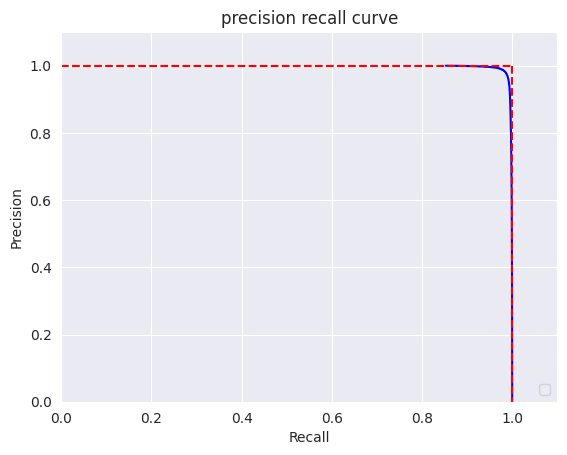

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(cv_true_labels, cv_predicted_labels)


# method I: plt
import matplotlib.pyplot as plt
plt.title('precision recall curve')
plt.plot(precision, recall, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 1],'r--')
plt.plot([1, 1], [1, 0],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

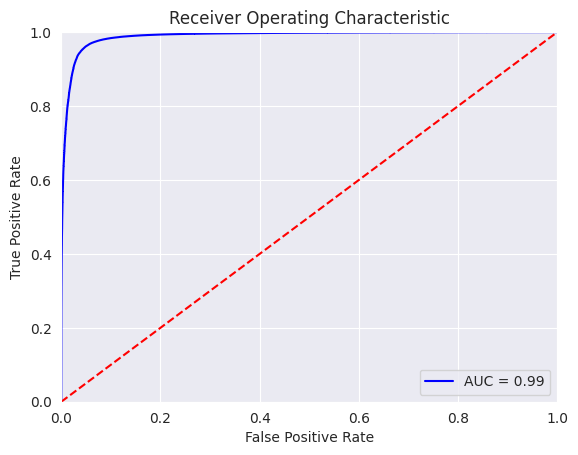

In [30]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(cv_true_labels, cv_predicted_labels)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
# Next we will evaluate the feature importance of the XGBoost model.
def evaluate_feature_importance(df_evaluate_feature_importance, md):
    feature_importance_average = [np.mean(i) for i in zip(*[md.get(model).feature_importances_ for model in md])]
    df_feature_importance = pd.DataFrame()
    df_feature_importance["Property"] = df_evaluate_feature_importance.columns
    df_feature_importance["Average_importance"] = feature_importance_average
    print(df_feature_importance.sort_values(by="Average_importance", ascending=False).head(50))

evaluate_feature_importance(df_evaluate_feature_importance=X_train_val.copy(), md=model_dict)

                                             Property  Average_importance
2                                           RC3-Score            0.372175
22                         better_match_10nt_start_ss            0.103836
18                                       3_MaxEntScan            0.071915
21                          better_match_5nt_start_ss            0.052620
20                                nearest_end_ss_dist            0.048316
19                              nearest_start_ss_dist            0.041096
17                                       5_MaxEntScan            0.039448
4           repeat_features_start_site:Tandem repeats            0.027330
1                               ss_antisense_end_site            0.021992
7                     repeat_features_start_site:LTRs            0.020854
14                      repeat_features_end_site:LTRs            0.019712
24                           better_match_10nt_end_ss            0.019549
5   repeat_features_start_site:Type I 

# Previous model:

| Metric               | Value                    | Standard Deviation       |
|----------------------|--------------------------|--------------------------|
| Accuracy             | 0.7983640800390435       | 0.007369779726815882     |
| AUCROC               | 0.868038309019828        | 0.011973584999514585     |
| MCC                  | 0.040672051294380555     | 0.0018166924023484236    |
| Sensitivity          | 0.7983729490685108       | 0.0073908204378677214    |
| Specificity          | 0.7869620253164558       | 0.03261376499333584      |
| Precision            | 0.9997921983516019       | 3.094276128538986e-05    |
| Recall               | 0.7983729490685108       |                          |
| False Positive Rate  | 0.21303797468354432      |                          |
| Balanced Accuracy    | 0.7926674871924831       | 0.014386556944333703     |


<br/>

|                     | Predicted Negative | Predicted Positive |
|---------------------|--------------------|--------------------|
| Actual Negative     | 314                | 85                 |
| Actual Positive     | 103203             | 408648             |



|                     | Model 1 | Model 2 (with simulated reads)| Model 2 + Antisense feature + more false introns |
|---------------------|---------|-------------------------------|-------------------------------------------------|
| Accuracy            | 0.798   | 0.955                         | 0.923                                           |
| MCC                 | 0.040   | 0.745                         | 0.786                                           |
| Precision           | 0.999   | 0.967                         | 0.942                                           |
| False Positive Rate | 0.213   | 0.291                         | 0.188                                           |
<br/>

|                     | Predicted Negative | Predicted Positive |
|---------------------|--------------------|--------------------|
| Actual Negative     | 101786             | 23678              |
| Actual Positive     | 16487              | 385967              |

The increase in MCC and Accuracy is significant, we have to account for the class imbalance in model 1 and that guarentees to have high precision rate and false positive rate, as now we have much more negatively-lablled data, the decrease in precision and increase false positive rate is still relatively low.
Overall we can conclude that generating the false-set helps the model greatly.

In [ ]:
df["prediction"] = y_predict_class

In [ ]:
X_train_val.to_csv("data/5-pred_result", sep="\t", index=False)

 # Improvements

We can see that Centromere, RNA repeats region, Unknown, and Dust region has the lowest importance, which is consistent with our hypothesis, we should be removing them from the features.

In [ ]:
X_train_val["class"] = y_train_val

In [ ]:
X_train_val[(X_train_val["class"] == 0)]["intron_length"].median()

In [ ]:
df[(df["class"] == 1) & (df["splice-site"] != 182)]

In [ ]:
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the correlation matrix
plt.figure(figsize=(30, 15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


values = np.vstack([df["splam_donor_score"], df["5_MaxEntScan"]])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=df,
    x="splam_donor_score",
    y="5_MaxEntScan",
    c=kernel,
    cmap="viridis",
    ax=ax,
)